In [1]:
import pandas as pd
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp
import numpy as np
from hyperopt import Trials, tpe, fmin
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier

In [2]:
ma = pd.read_csv("../16 Mycoplosma/ma.csv")
map = pd.read_csv("../16 Mycoplosma/map.csv")
marth = pd.read_csv("../16 Mycoplosma/marth.csv")
mcap = pd.read_csv("../16 Mycoplosma/mcap.csv")
mcon = pd.read_csv("../16 Mycoplosma/mcon.csv")
mcro = pd.read_csv("../16 Mycoplosma/mcro.csv")
mgal = pd.read_csv("../16 Mycoplosma/mgal.csv")
mhom = pd.read_csv("../16 Mycoplosma/mhom.csv")
mhyoJ = pd.read_csv("../16 Mycoplosma/mhyoJ.csv")
mhyo232 = pd.read_csv("../16 Mycoplosma/mhyo232.csv")
mhyo7448 = pd.read_csv("../16 Mycoplosma/mhyo7448.csv")
mm163K = pd.read_csv("../16 Mycoplosma/mm163K.csv")
mms = pd.read_csv("../16 Mycoplosma/mms.csv")
mpHF = pd.read_csv("../16 Mycoplosma/mpHF.csv")
mpM = pd.read_csv("../16 Mycoplosma/mpM.csv")
ms53 = pd.read_csv("../16 Mycoplosma/ms53.csv")

In [3]:
def generate_train_test_dataset(index):
    dataset_names = [ma, map, marth, mcap, mcon, mcro, mgal, mhom, mhyoJ, mhyo232, mhyo7448, mm163K, mms, mpHF, mpM, ms53]
    merged_train = dataset_names[:index]+dataset_names[index+1:]
    train_data = pd.concat(merged_train)
    test_data = dataset_names[index]
    return train_data,test_data

In [4]:
train_data , test_data = generate_train_test_dataset(0)

In [5]:
def handle_dataset(dataset):
    columns_to_drop = ['identity','name', 'Amino acid', 'protein_sequence', 'essentiality']
    Xs = dataset.drop(columns = columns_to_drop)
    y = dataset['essentiality']
    return Xs,y

In [6]:
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)

In [8]:
from xgboost import XGBClassifier

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
def xgb_bca_cv(params):
    scorer = make_scorer(balanced_accuracy_score)
    model = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        objective='binary:logistic'  # 二分类问题
    )
    score = -cross_val_score(model, X_resampled, y_resampled, cv=5,scoring=scorer, ).mean()
    return score

In [9]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),  # 树的数量
    'max_depth': hp.quniform('max_depth', 3, 10, 1),  # 每棵树的最大深度
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  # 学习率
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # 每棵树的样本采样比例
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # 每棵树的特征采样比例
    'gamma': hp.loguniform('gamma', -3, 2),  # 节点分裂时损失函数减小值的最小值要求
    'reg_alpha': hp.loguniform('reg_alpha', -3, 2),  # L1 正则化项系数
    'reg_lambda': hp.loguniform('reg_lambda', -3, 2),  # L2 正则化项系数
}

In [10]:

trials = Trials()

best=fmin(fn=xgb_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )


100%|██████████| 100/100 [02:53<00:00,  1.73s/trial, best loss: -0.8668887330528283]


In [11]:
model_resampled = XGBClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    objective='binary:logistic'  # 二分类问题
)
model_resampled.fit(X_resampled,y_resampled)
test_score = balanced_accuracy_score(y_test,model_resampled.predict(Xs_test))
print(test_score)

0.9090518300171948


In [12]:
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#feature selection
#RFE
score = []
scorer = make_scorer(balanced_accuracy_score)
for i in range(26,5,-1):
	X_mutual = SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(X_resampled, y_resampled)
	once = cross_val_score(model_resampled, X_mutual, y_resampled, cv=10,scoring=scorer)
	score.append(once.mean())


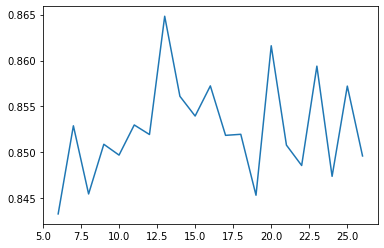

In [13]:
plt.plot(range(26,5,-1), score)
plt.show()    

In [14]:
from sklearn.feature_selection import RFECV

X_mutual = SelectKBest(score_func=mutual_info_classif, k=13).fit_transform(X_resampled, y_resampled)
rfecv = RFECV(estimator=model_resampled,  
              min_features_to_select=5, 
              step=1,               
              cv=5,
              verbose = 1,
              n_jobs = 1
              ).fit(X_mutual,y_resampled)
X_RFECV = rfecv.transform(X_mutual)
print("RFECVresult——————————————————————————————————————————————————")
print("valid : %d" % rfecv.n_features_)
print("ranking : %s" % list(rfecv.ranking_))

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitt

In [15]:
all_feature_names = ["GC_Content","CAI","A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V","SE2","SE3","GE2","GE3"]
selected_feature_names = [all_feature_names[i] for i, rank in enumerate(rfecv.ranking_) if rank == 1]

print("Selected feature names:", selected_feature_names)

Selected feature names: ['GC_Content', 'CAI', 'A', 'R', 'D', 'G']


In [16]:
Wrapper_score = cross_val_score(model_resampled,X_RFECV,y_resampled,cv=5,scoring=scorer).mean()
print(Wrapper_score)

0.8635226741467976


In [19]:
model_resampled.fit(X_resampled,y_resampled)
Xs_test_mutual = SelectKBest(mutual_info_classif, k=13).fit_transform(Xs_test,y_test)
Xs_test_rfe = rfecv.transform(Xs_test_mutual)
test_score = balanced_accuracy_score(y_test, model_resampled.predict(Xs_test))
print(test_score)

0.9090518300171948


In [20]:
def feature_selection(Xs,y):
    Xs_result = SelectKBest(mutual_info_classif, k=13).fit_transform(Xs,y)
    Xs_result = rfecv.transform(Xs_result)
    return Xs_result

In [21]:
models= []
score = 0
scores = []

for i in range(0,15):
    if i == 3 :
        scores.append(0.5127968346578312)
        continue
    if i ==12:
        scores.append(0.5123582987129056)
        continue
    train_data, test_data = generate_train_test_dataset(i)
    Xs_train,y_train = handle_dataset(train_data)
    Xs_test,y_test = handle_dataset(test_data)
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
    X_resampled = feature_selection(X_resampled,y_resampled)
    trials = Trials()
    best=fmin(fn=xgb_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
    )
    model = XGBClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    objective='binary:logistic'  # 二分类问题
)
    models.append(model)
    model.fit(X_resampled,y_resampled)
    Xs_test_fs = feature_selection(Xs_test,y_test)
    tpe_test_score=balanced_accuracy_score(y_test, model.predict(Xs_test_fs))
    scores.append(tpe_test_score)
    print(tpe_test_score)
    if score < tpe_test_score:
        score = tpe_test_score
        best_model = model

100%|██████████| 50/50 [00:44<00:00,  1.13trial/s, best loss: -0.8679406264609633]
0.5
100%|██████████| 50/50 [00:52<00:00,  1.06s/trial, best loss: -0.8681318681318683]
0.5
100%|██████████| 50/50 [00:45<00:00,  1.10trial/s, best loss: -0.8711164493250972]
0.5016556291390728
100%|██████████| 50/50 [00:47<00:00,  1.05trial/s, best loss: -0.8670441546556852]
0.7238127893022458
100%|██████████| 50/50 [00:45<00:00,  1.09trial/s, best loss: -0.8661371237458194]
0.5
100%|██████████| 50/50 [00:42<00:00,  1.18trial/s, best loss: -0.8634992987377279]
0.5
100%|██████████| 50/50 [00:50<00:00,  1.01s/trial, best loss: -0.8723747426218257]
0.5017182130584192
100%|██████████| 50/50 [00:45<00:00,  1.09trial/s, best loss: -0.8604781514527566]
0.5015151515151515
100%|██████████| 50/50 [00:43<00:00,  1.15trial/s, best loss: -0.8558730158730159]
0.7122512010981469
100%|██████████| 50/50 [00:44<00:00,  1.11trial/s, best loss: -0.8647563486616334]
0.8484848484848485
100%|██████████| 50/50 [00:40<00:00,  1.

In [22]:
print(scores)

[0.5, 0.5, 0.5016556291390728, 0.5127968346578312, 0.7238127893022458, 0.5, 0.5, 0.5017182130584192, 0.5015151515151515, 0.7122512010981469, 0.8484848484848485, 0.501466275659824, 0.5123582987129056, 0.5705128205128205, 0.5017301038062284]


In [23]:
train_data, test_data = generate_train_test_dataset(4)
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
X_resampled = feature_selection(X_resampled,y_resampled)
trials = Trials()
best=fmin(fn=xgb_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
          )
model = XGBClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    objective='binary:logistic'  # 二分类问题
)

100%|██████████| 50/50 [00:49<00:00,  1.00trial/s, best loss: -0.8670441546556852]


In [24]:
model.fit(X_resampled,y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6883911538370099, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.12162462933487812,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.19705465828411872,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
from joblib import dump

dump(model, '../../model/XGB_FS_model.joblib')

['../../model/XGB_FS_model.joblib']

In [26]:
models_nfs= []
score = 0
scores_nfs = []
for i in range(0,15):
    train_data, test_data = generate_train_test_dataset(i)
    Xs_train,y_train = handle_dataset(train_data)
    Xs_test,y_test = handle_dataset(test_data)
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
    trials = Trials()
    best=fmin(fn=xgb_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
    )
    model = XGBClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    objective='binary:logistic'  # 二分类问题
)
    models_nfs.append(model)
    model.fit(X_resampled,y_resampled)
    tpe_test_score=balanced_accuracy_score(y_test, model.predict(Xs_test))
    scores_nfs.append(tpe_test_score)
    print(tpe_test_score)
    if score < tpe_test_score:
        score = tpe_test_score
        best_model_nfs = model

100%|██████████| 50/50 [01:25<00:00,  1.71s/trial, best loss: -0.8668887330528283]
0.9090518300171948
100%|██████████| 50/50 [02:03<00:00,  2.47s/trial, best loss: -0.8780219780219781]
0.8448123620309052
100%|██████████| 50/50 [02:07<00:00,  2.55s/trial, best loss: -0.8689659116906887]
0.6686672185430463
100%|██████████| 50/50 [02:18<00:00,  2.77s/trial, best loss: -0.8581400343642611]
0.9465020576131687
100%|██████████| 50/50 [02:01<00:00,  2.43s/trial, best loss: -0.8648936170212768]
0.8195611177781588
100%|██████████| 50/50 [02:07<00:00,  2.55s/trial, best loss: -0.8748924988055423]
0.8788696060037524
100%|██████████| 50/50 [01:33<00:00,  1.87s/trial, best loss: -0.8722417017297802]
0.8385730211817168
100%|██████████| 50/50 [01:34<00:00,  1.88s/trial, best loss: -0.8745710363761153]
0.9181587990595044
100%|██████████| 50/50 [01:27<00:00,  1.75s/trial, best loss: -0.883848089681995] 
0.834469696969697
100%|██████████| 50/50 [02:09<00:00,  2.59s/trial, best loss: -0.856947496947497] 


In [27]:
print(scores_nfs)

[0.9090518300171948, 0.8448123620309052, 0.6686672185430463, 0.9465020576131687, 0.8195611177781588, 0.8788696060037524, 0.8385730211817168, 0.9181587990595044, 0.834469696969697, 0.9352387488969507, 0.9142045454545454, 0.8658357771260997, 0.8621212121212121, 0.917948717948718, 0.58776268039497]


In [28]:
train_data, test_data = generate_train_test_dataset(3)
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
trials = Trials()
best=fmin(fn=xgb_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
    )
best_model = XGBClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    objective='binary:logistic'  # 二分类问题
)

 12%|█▏        | 6/50 [00:11<01:21,  1.86s/trial, best loss: -0.8498389175257733]


KeyboardInterrupt: 

In [29]:
best_model = models_nfs[3]

In [30]:
from joblib import dump
best_model.fit(X_resampled,y_resampled)
dump(best_model, '../../model/XGB_model.joblib')

['../../model/XGB_model.joblib']

In [102]:
print(scores_nfs)
#[0.8201301891427167, 0.7593818984547461, 0.6254139072847682, 0.4835390946502058, 0.7308417623864221, 0.7671200750469043, 0.7566332218506131, 0.7545668294447458, 0.7363636363636363, 0.8050299048926366, 0.7946969696969697, 0.6348973607038123, 0.6936868686868687, 0.7435897435897436, 0.6010886994683096]

[0.8201301891427167, 0.7593818984547461, 0.6254139072847682, 0.4835390946502058, 0.7308417623864221, 0.7671200750469043, 0.7566332218506131, 0.7545668294447458, 0.7363636363636363, 0.8050299048926366, 0.7946969696969697, 0.6348973607038123, 0.6936868686868687, 0.7435897435897436, 0.6010886994683096]


In [105]:
train_data, test_data = generate_train_test_dataset(0)
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
trials = Trials()
best=fmin(fn=rf_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
          )
best_model = RandomForestClassifier(random_state=42, n_estimators=int(best['n_estimators']),max_depth=int(best['max_depth']),min_samples_split=best['min_samples_split'],min_samples_leaf=best['min_samples_leaf'])
best_model.fit(X_resampled,y_resampled)

100%|██████████| 50/50 [02:35<00:00,  3.12s/trial, best loss: -0.8148784478728377]


RandomForestClassifier(max_depth=18, min_samples_leaf=0.10030016223764829,
                       min_samples_split=0.2591505195174929, n_estimators=690,
                       random_state=42)

In [106]:
dump(best_model, '../../model/RF_model.joblib')

['../../model/RF_model.joblib']